In [2]:
import os
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm, ListedColormap

from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import colorcet as cc
import warnings 

In [3]:
class SpatialMetricPlotter:
    def __init__(self, mask_path, projection=ccrs.PlateCarree()):
        self.projection = projection
        self.land_mask = self.set_land_mask(mask_path)   

    def set_land_mask(self, mask_path):
        """
        Set a land mask where land = 1 and ocean = 0. 
        Used to mask out oceans for certain variables like TS.
        """
        land_frac = xr.open_dataset(mask_path)["landfrac"]
        if land_frac.lon.min() >= 0:
            land_frac = land_frac.assign_coords(lon=((land_frac.lon + 180) % 360 - 180)).sortby("lon")
        mask_da = xr.where(land_frac > 0.1, 1, 0) # or > 0.1 if you want to include partial land
        return mask_da
    
    def _create_discrete_colormap_with_white_zero(self, base_cmap, clevels, white_width=1):
        N = len(clevels) + 1
        cmap_colors = base_cmap(np.linspace(0, 1, N + white_width))
        mid = len(cmap_colors) // 2
        if white_width == 1:
            cmap_colors[mid-1:mid+1] = [1.0, 1.0, 1.0, 1.0]
        else:
            half = white_width // 2
            cmap_colors[mid - half: mid + half+1] = [1.0, 1.0, 1.0, 1.0]
        if len(cmap_colors) > N:
            idx_start = (len(cmap_colors) - N) // 2
            cmap_colors = cmap_colors[idx_start:idx_start + N]
        return ListedColormap(cmap_colors)

    def plot_variable_metric(self, out_path, fig_path, model_dict, var, vinfo,
                             data_key, metric_key, mask_lower=None, mask_upper=None,
                             season="ANN", cmap=None, epsilon=0.1):

        os.makedirs(fig_path, exist_ok=True)

        if cmap is None:
            try:
                from cmocean import cm as cc
                cmap = cc.balance
            except ImportError:
                print("[WARN] Using fallback colormap 'RdBu_r'")
                cmap = plt.get_cmap("RdBu_r")

        fontz = 14
        tick_fontz = 12
        ncol = len(model_dict)
        fig = plt.figure(figsize=(4.5 * ncol + 2, 3.5))
        clevels = np.unique(np.sort(np.array(vinfo["level"])))
        
        start_time = time.time()

        use_ratio = metric_key == "spread_map"
        if use_ratio:
            clevels = np.linspace(0, 1.6, 9)
            cmap_discrete = plt.get_cmap("YlGnBu", len(clevels) - 1)
            norm = BoundaryNorm(clevels, ncolors=cmap_discrete.N)
        elif metric_key in ["rmse_map",'crps_map']: 
            raw_levels = np.array(vinfo["level"])
            clevels = np.linspace(0,raw_levels.max(),int(raw_levels.max())+1)
            cmap_discrete = plt.get_cmap("YlGnBu", len(clevels) - 1)
            norm = BoundaryNorm(clevels, ncolors=cmap_discrete.N)
        else:
            cmap_discrete = self._create_discrete_colormap_with_white_zero(cmap, clevels, white_width=1)
            norm = BoundaryNorm(clevels, ncolors=len(cmap_discrete.colors), extend='both')

        cf_last = None

        for j, model in enumerate(model_dict):
            ax = plt.subplot(1, ncol, j + 1, projection=self.projection)
            nc_file = os.path.join(out_path, f"{model}_{var}_{data_key}.nc")
            
            ax.set_global()
            if not os.path.exists(nc_file):
                ax.set_title(f"{model}\n[Missing]", fontsize=fontz)
                ax.axis("off")
                continue

            try:
                ds = xr.open_dataset(nc_file)
            except Exception:
                ax.set_title(f"{model}\n[Read Error]", fontsize=fontz)
                ax.axis("off")
                continue

            if metric_key not in ds:
                ax.set_title(f"{model}\n[No {metric_key}]", fontsize=fontz)
                ax.axis("off")
                continue

            metric = ds[metric_key].sel(var=var) if var in ds[metric_key].dims else ds[metric_key]
            if use_ratio:
                if "rmse_map" not in ds:
                    ax.set_title(f"{model}\n[Missing RMSE]", fontsize=fontz)
                    ax.axis("off")
                    continue
                rmse = ds["rmse_map"].sel(var=var) if var in ds["rmse_map"].dims else ds["rmse_map"]
                metric = metric / rmse
                metric.attrs["long_name"] = "Spread / RMSE"

            lower = ds[mask_lower].sel(var=var) if mask_lower in ds and var in ds[mask_lower].dims else ds.get(mask_lower)
            upper = ds[mask_upper].sel(var=var) if mask_upper in ds and var in ds[mask_upper].dims else ds.get(mask_upper)
            sig_mask = xr.where((lower > 0) | (upper < 0), 1, np.nan) if lower is not None and upper is not None else None

            masked_metric = metric.where((metric < -epsilon) | (metric > epsilon))

            # Apply land mask to TS if requested
            if var == "TS" and self.land_mask is not None:
                masked_metric = masked_metric.where(self.land_mask == 1)
                if sig_mask is not None:
                    sig_mask = sig_mask.where(self.land_mask == 1)
        
            cf = ax.contourf(masked_metric.lon, masked_metric.lat, masked_metric,
                             levels=clevels, cmap=cmap_discrete, norm=norm, extend="both",
                             transform=ccrs.PlateCarree())
            cf_last = cf

            if sig_mask is not None:
                ax.contourf(sig_mask.lon, sig_mask.lat, sig_mask.fillna(0),
                            levels=[0.5, 1.5], colors='none', hatches=['..', '..'],
                            transform=ccrs.PlateCarree(), zorder=10)

            ax.coastlines(linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': tick_fontz}
            gl.ylabel_style = {'size': tick_fontz}
            ax.set_title(model_dict[model], fontsize=fontz)

        if cf_last:
            cbar_ax = fig.add_axes([0.92, 0.18, 0.012, 0.6])
            cbar = fig.colorbar(cf_last, cax=cbar_ax)
            unit_label = "unitless" if use_ratio else vinfo["unit"]
            cbar.set_label(f"{vinfo['alias']} ({unit_label})", fontsize=fontz + 1)
            #cbar.locator = MaxNLocator(nbins=5, steps=[1, 2, 5, 10], prune='both')
            #cbar.update_ticks()
            cbar.ax.tick_params(labelsize=tick_fontz)
            for spine in cbar.ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(0.5)
                spine.set_edgecolor("black")

        plt.subplots_adjust(left=0.06, right=0.90, top=0.90, bottom=0.08, wspace=0.15)
        fig_file = os.path.join(fig_path, f"{var}_{metric_key}_{season}.pdf")
        plt.savefig(fig_file, dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"[INFO] Saved: {fig_file} in {time.time() - start_time:.2f} sec.")


[WARN] Using fallback colormap 'RdBu_r'


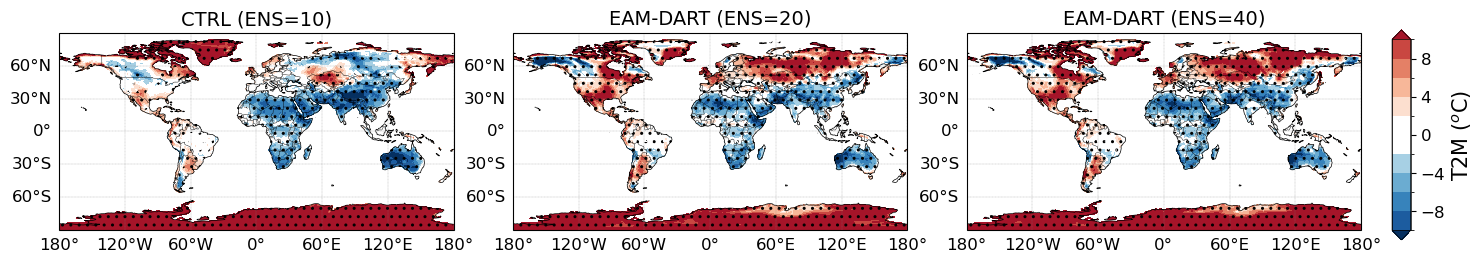

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TSA_bias_map_DEC2011.pdf in 4.31 sec.
[WARN] Using fallback colormap 'RdBu_r'


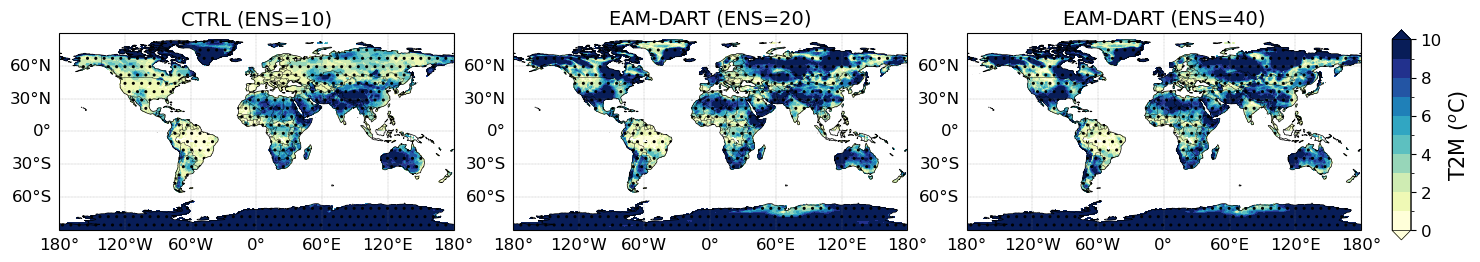

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TSA_crps_map_DEC2011.pdf in 2.38 sec.
[WARN] Using fallback colormap 'RdBu_r'


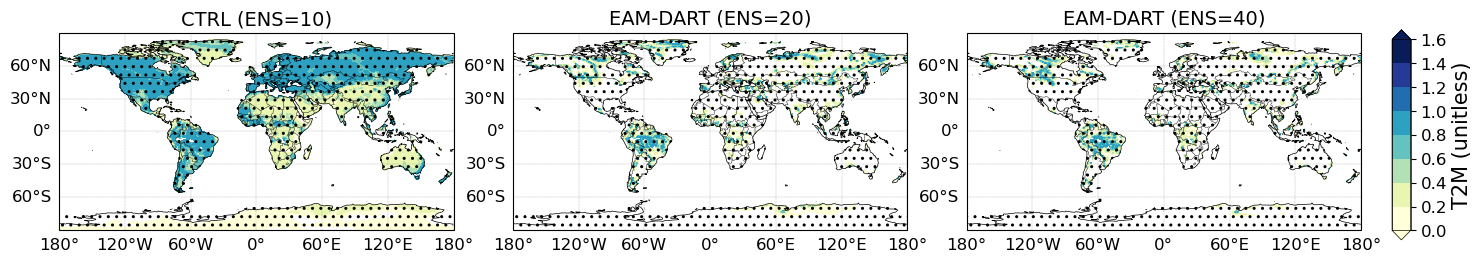

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TSA_spread_map_DEC2011.pdf in 1.98 sec.
[WARN] Using fallback colormap 'RdBu_r'


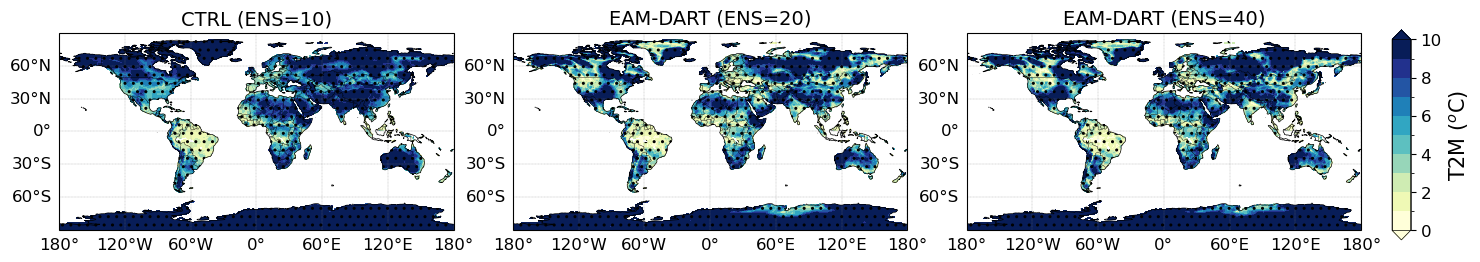

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TSA_rmse_map_DEC2011.pdf in 2.20 sec.
[WARN] Using fallback colormap 'RdBu_r'


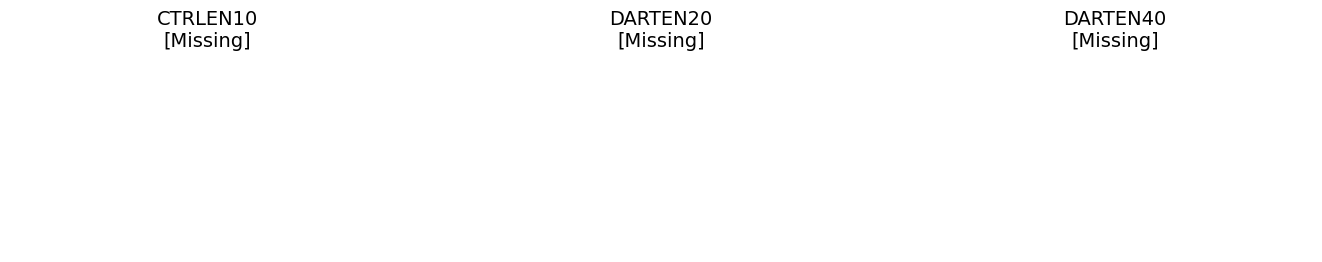

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/H2OSOI_bias_map_DEC2011.pdf in 0.09 sec.
[WARN] Using fallback colormap 'RdBu_r'


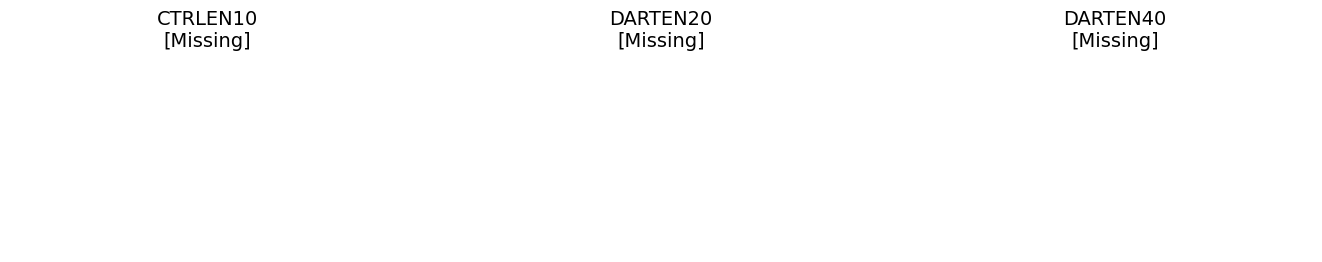

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/H2OSOI_crps_map_DEC2011.pdf in 0.08 sec.
[WARN] Using fallback colormap 'RdBu_r'


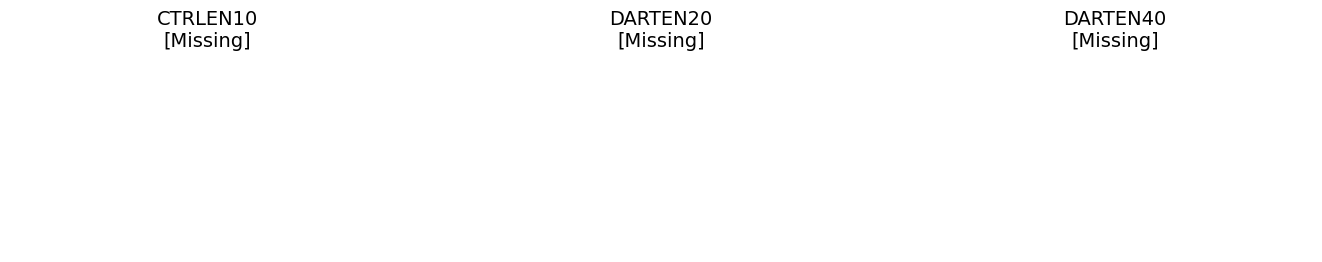

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/H2OSOI_spread_map_DEC2011.pdf in 0.07 sec.
[WARN] Using fallback colormap 'RdBu_r'


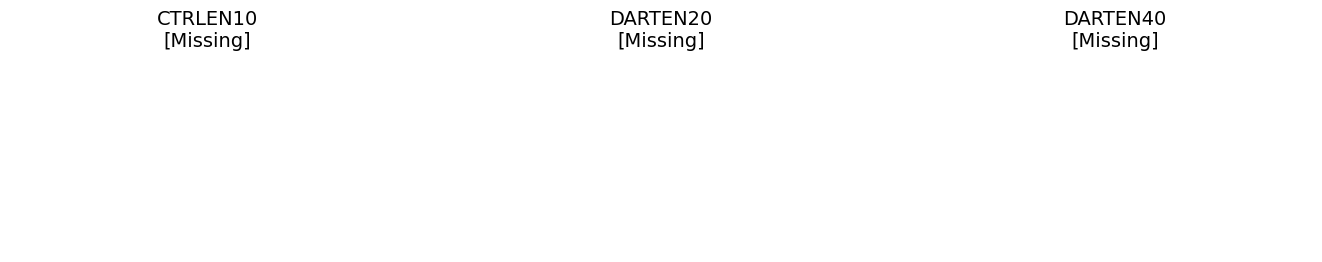

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/H2OSOI_rmse_map_DEC2011.pdf in 0.07 sec.
[WARN] Using fallback colormap 'RdBu_r'


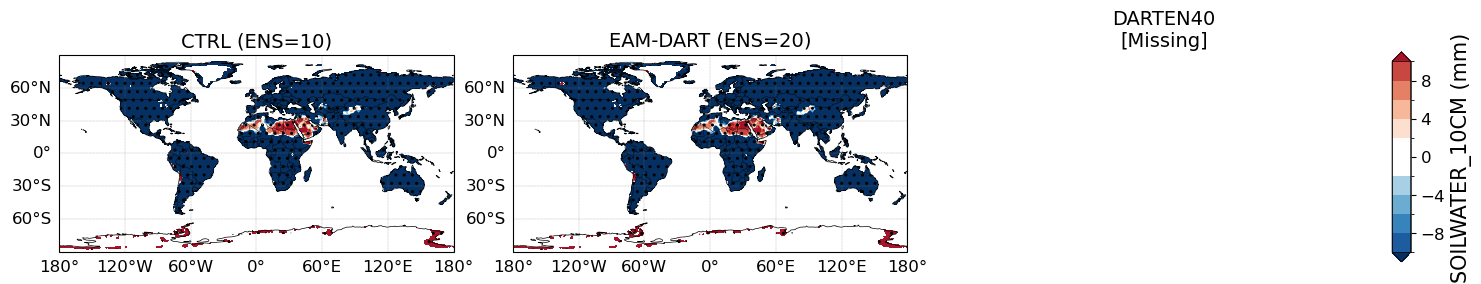

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/SOILWATER_10CM_bias_map_DEC2011.pdf in 1.48 sec.
[WARN] Using fallback colormap 'RdBu_r'


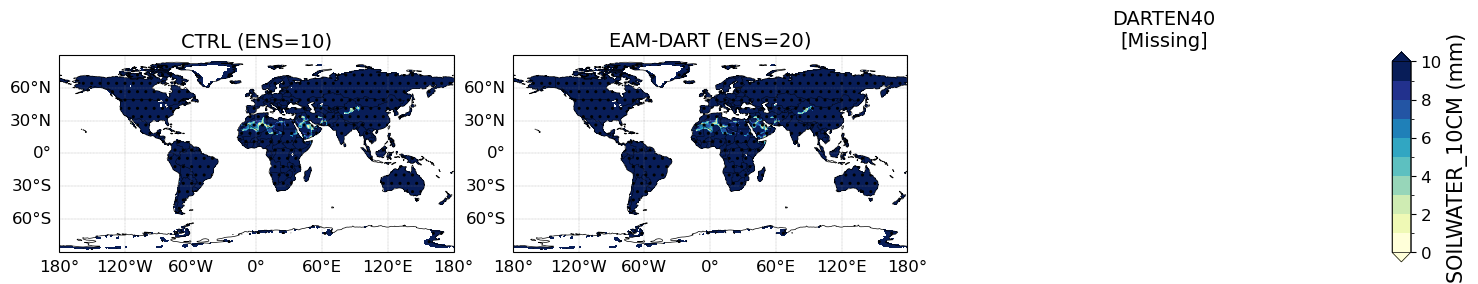

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/SOILWATER_10CM_crps_map_DEC2011.pdf in 1.28 sec.
[WARN] Using fallback colormap 'RdBu_r'


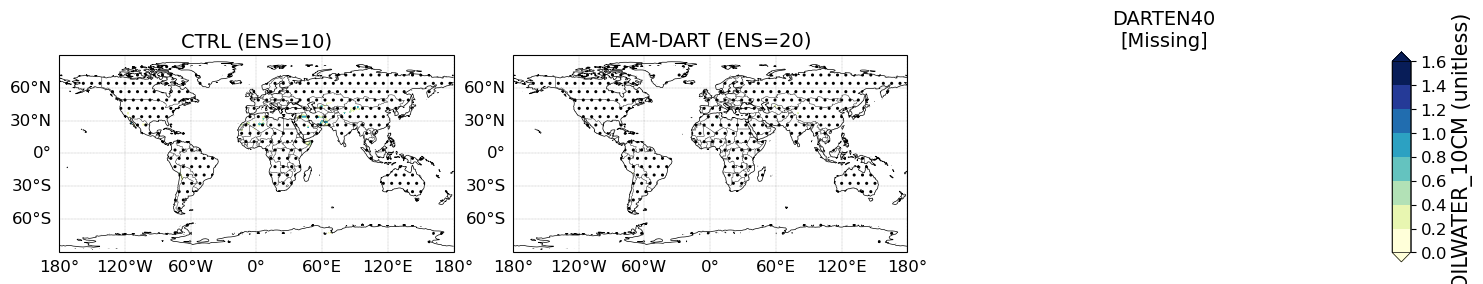

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/SOILWATER_10CM_spread_map_DEC2011.pdf in 1.19 sec.
[WARN] Using fallback colormap 'RdBu_r'


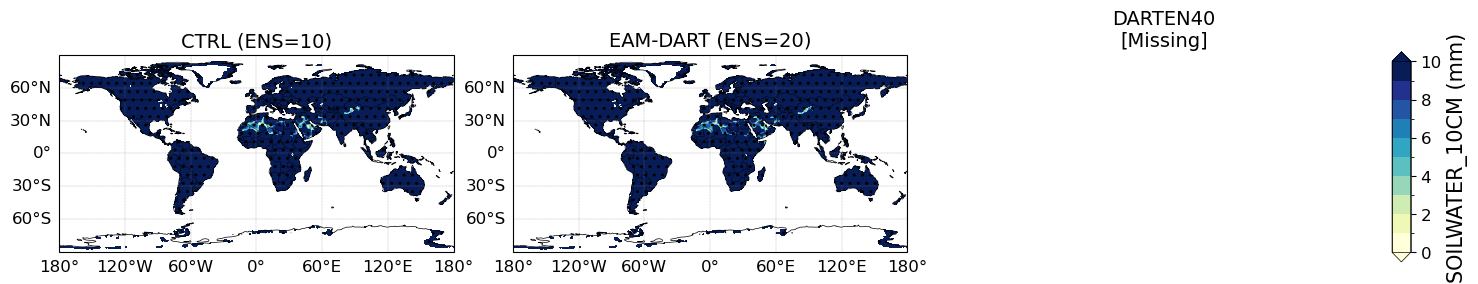

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/SOILWATER_10CM_rmse_map_DEC2011.pdf in 1.17 sec.


In [5]:
if __name__ == "__main__":
    top_path = "/compyfs/zhan391/v3_dart_cda_scratch"
    out_path = os.path.join(top_path, "diag_dart")
    fig_path = "/qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da"
    mask_path = os.path.join(out_path,'landmask_1x1.nc')
    
    compset = "F20TR"
    resolution = "ne30pg2_r05_IcoswISC30E3r5"
    machine = "compy"
    exp_base = f"{compset}_{resolution}_{machine}"

    regnam = "global"
    period = "2011-12"
    frequency = "monthly"
    season = "DEC2011"
    var_dict = {
        'TSA': {'alias': 'T2M', 'unit': '$^o$C', 'level': np.linspace(-10, 10, 11), 'comp': 'lnd', 'ref': "MODIS_LST"},
        'H2OSOI': {'alias': 'H2OSOI', 'unit': 'mm', 'level': np.linspace(-10, 10, 11), 'comp': 'lnd', 'ref': "ESA_CCI"},
        'SOILWATER_10CM': {'alias': 'SOILWATER_10CM', 'unit': 'mm', 'level': np.linspace(-10, 10, 11), 'comp': 'lnd', 'ref': "CPC_SOM"},
    }
    
    model_dict = {
        'CTRLEN10': "CTRL (ENS=10)",
        'DARTEN20': "EAM-DART (ENS=20)",
        'DARTEN40': "EAM-DART (ENS=40)",
        # You can include others like 'DARTEN10' or 'DARTEN80' if available
    }

    os.makedirs(out_path, exist_ok=True)
    os.makedirs(fig_path, exist_ok=True)

    plotter = SpatialMetricPlotter(mask_path)
    # Colormap: safe colorblind-friendly diverging
    cmap = cc.cm["CET_C9s"]  # Good for centered differences
    
    group_key = "ensemble_mean_bias"
    for var, vinfo in var_dict.items():
        for metric_key, mask_lower, mask_upper, metric_title in [
            ("bias_map", "bias_map_ci_lower","bias_map_ci_upper", "Mean Bias"),
            ("crps_map", "crps_map_ci_lower","crps_map_ci_upper", "CRPS"),
            ("spread_map", "spread_map_ci_lower","spread_map_ci_upper","Ensemble Spread"),
            ("rmse_map", "rmse_map_ci_lower","rmse_map_ci_upper", "RMSE")
        ]:
            try:
                plotter.plot_variable_metric(
                    out_path=out_path,
                    fig_path=fig_path,
                    model_dict=model_dict,
                    var=var,
                    vinfo=vinfo,
                    data_key=group_key,
                    metric_key=metric_key,
                    mask_lower=mask_lower,
                    mask_upper=mask_upper,
                    season=season
                )
            except Exception as e:
                print(f"[ERROR] Failed {var} {metric_key}: {e}")

In [ ]:
if __name__ == "__main__":
    top_path = "/compyfs/zhan391/v3_dart_cda_scratch"
    out_path = os.path.join(top_path, "diag_dart")
    fig_path = "/qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da"
    mask_path = os.path.join(out_path,'landmask_1x1.nc')
    
    compset = "F20TR"
    resolution = "ne30pg2_r05_IcoswISC30E3r5"
    machine = "compy"
    exp_base = f"{compset}_{resolution}_{machine}"

    regnam = "global"
    period = "2011-12"
    frequency = "monthly"
    season = "DEC2011"
    var_dict = {
        'TMQ': {'alias': 'TMQ', 'unit': 'kg m$^{-2}$', 'level': np.linspace(-10, 10, 11), 'comp': 'atm', 'ref': "ERA5"},
        'FLUT': {'alias': 'FLUT', 'unit': 'W m$^{-2}$', 'level': np.linspace(-10, 10, 11), 'comp': 'atm', 'ref': "CERES-OAFlux"},
    }
    
    model_dict = {
        'CTRLEN10': "CTRL (ENS=10)",
        'DARTEN20': "EAM-DART (ENS=20)",
        'DARTEN40': "EAM-DART (ENS=40)",
        # You can include others like 'DARTEN10' or 'DARTEN80' if available
    }

    os.makedirs(out_path, exist_ok=True)
    os.makedirs(fig_path, exist_ok=True)

    plotter = SpatialMetricPlotter(mask_path)
    # Colormap: safe colorblind-friendly diverging
    cmap = cc.cm["CET_C9s"]  # Good for centered differences
    
    group_key = "ensemble_mean_bias"
    for var, vinfo in var_dict.items():
        for metric_key, mask_lower, mask_upper, metric_title in [
            ("bias_map", "bias_map_ci_lower","bias_map_ci_upper", "Mean Bias"),
            ("crps_map", "crps_map_ci_lower","crps_map_ci_upper", "CRPS"),
            ("spread_map", "spread_map_ci_lower","spread_map_ci_upper","Ensemble Spread"),
            ("rmse_map", "rmse_map_ci_lower","rmse_map_ci_upper", "RMSE")
        ]:
            try:
                plotter.plot_variable_metric(
                    out_path=out_path,
                    fig_path=fig_path,
                    model_dict=model_dict,
                    var=var,
                    vinfo=vinfo,
                    data_key=group_key,
                    metric_key=metric_key,
                    mask_lower=mask_lower,
                    mask_upper=mask_upper,
                    season=season
                )
            except Exception as e:
                print(f"[ERROR] Failed {var} {metric_key}: {e}")


[WARN] Using fallback colormap 'RdBu_r'


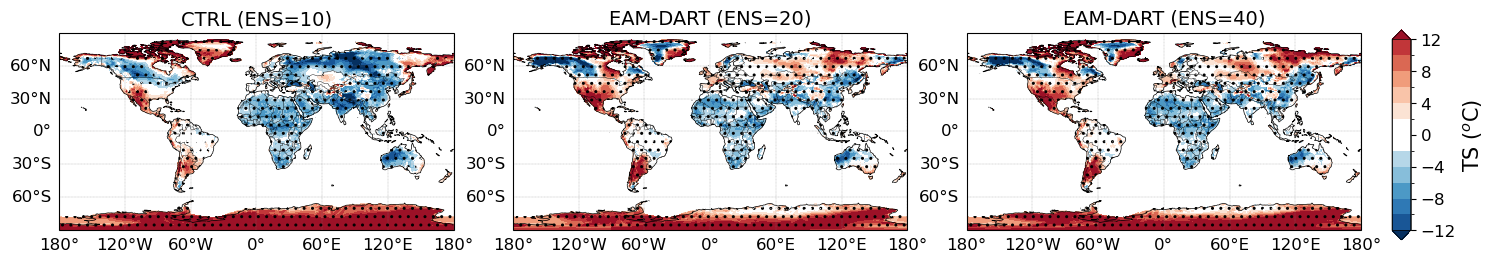

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TS_bias_map_DEC2011.pdf in 2.30 sec.
[WARN] Using fallback colormap 'RdBu_r'


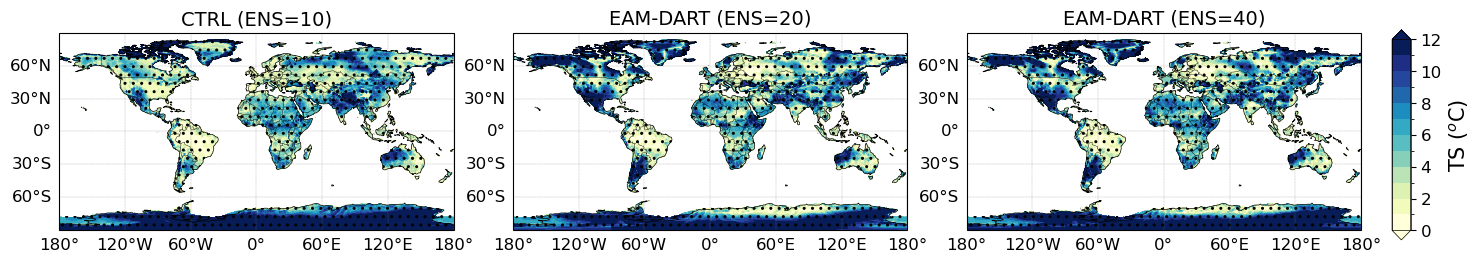

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TS_crps_map_DEC2011.pdf in 2.31 sec.
[WARN] Using fallback colormap 'RdBu_r'


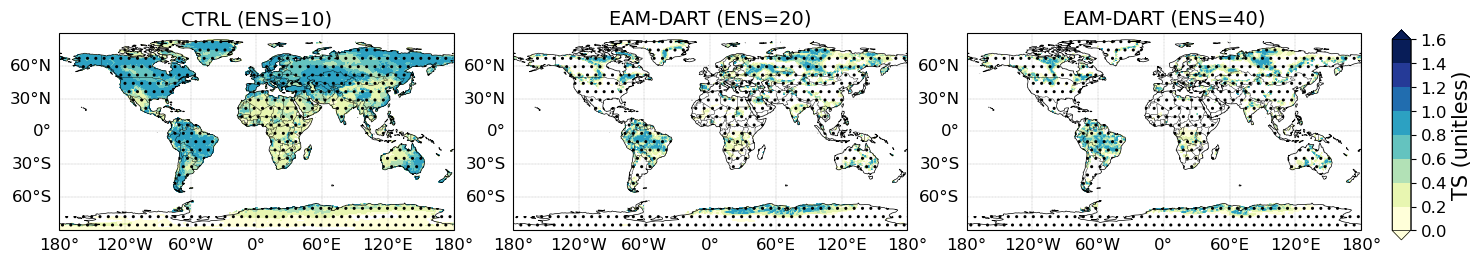

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TS_spread_map_DEC2011.pdf in 1.72 sec.
[WARN] Using fallback colormap 'RdBu_r'


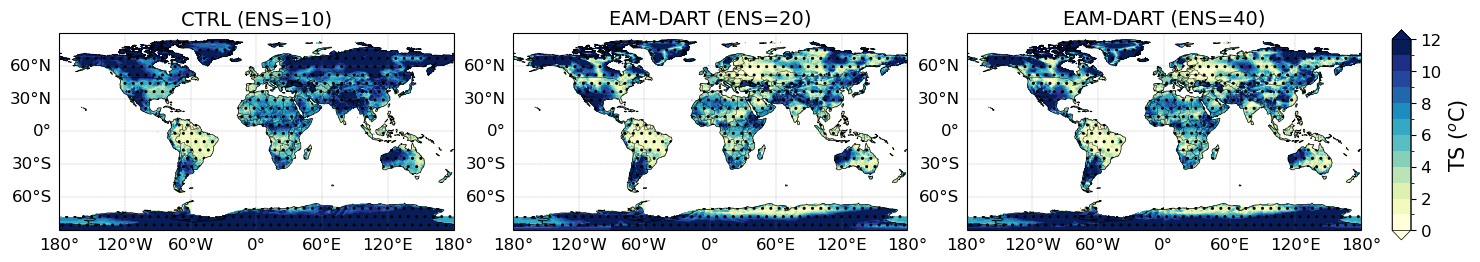

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TS_rmse_map_DEC2011.pdf in 2.46 sec.
[WARN] Using fallback colormap 'RdBu_r'


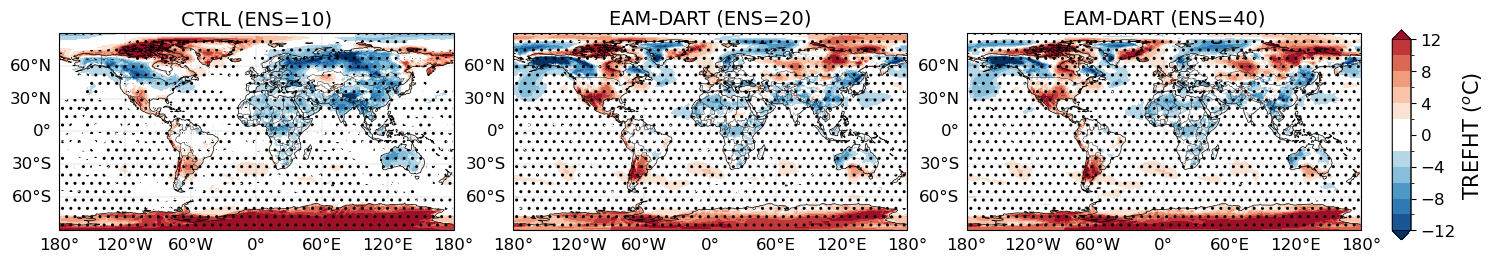

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TREFHT_bias_map_DEC2011.pdf in 2.29 sec.
[WARN] Using fallback colormap 'RdBu_r'


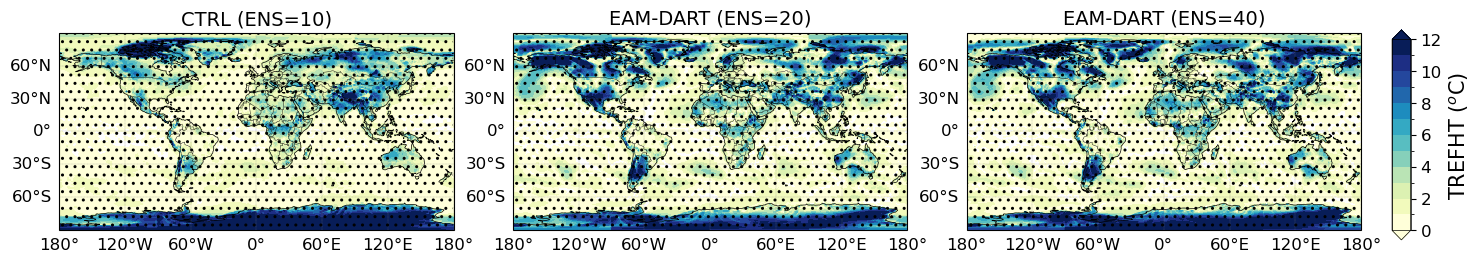

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TREFHT_crps_map_DEC2011.pdf in 2.53 sec.
[WARN] Using fallback colormap 'RdBu_r'


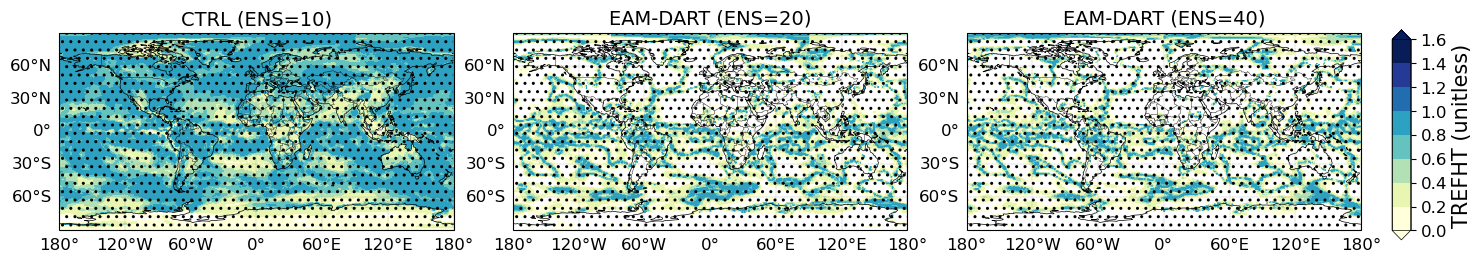

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TREFHT_spread_map_DEC2011.pdf in 2.31 sec.
[WARN] Using fallback colormap 'RdBu_r'


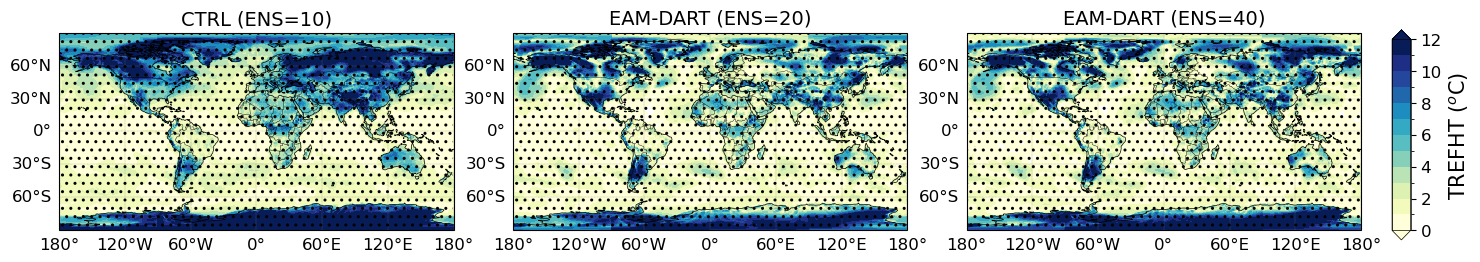

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/TREFHT_rmse_map_DEC2011.pdf in 2.58 sec.
[WARN] Using fallback colormap 'RdBu_r'


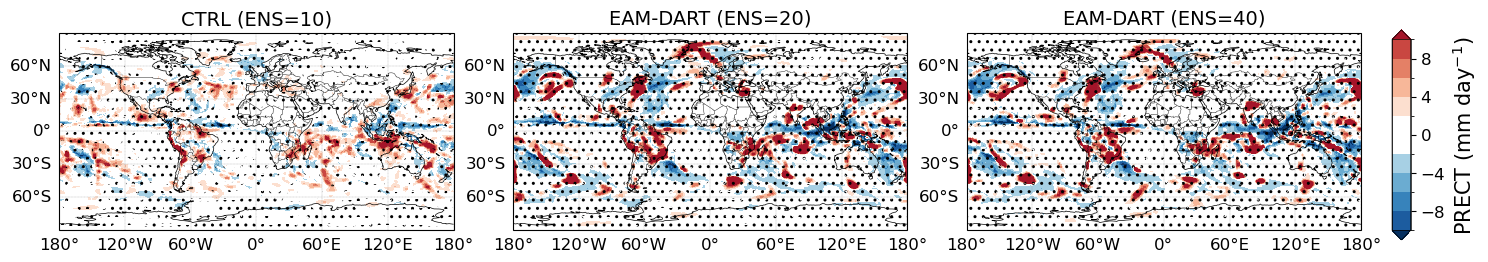

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PRECT_bias_map_DEC2011.pdf in 2.33 sec.
[WARN] Using fallback colormap 'RdBu_r'


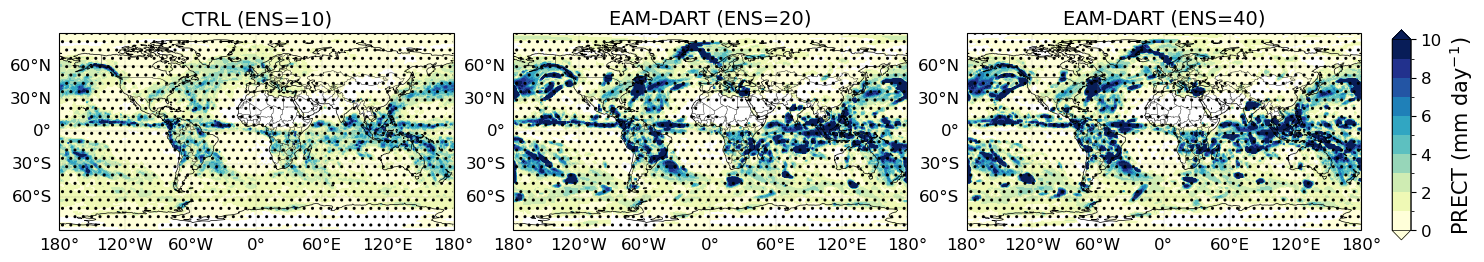

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PRECT_crps_map_DEC2011.pdf in 3.20 sec.
[WARN] Using fallback colormap 'RdBu_r'


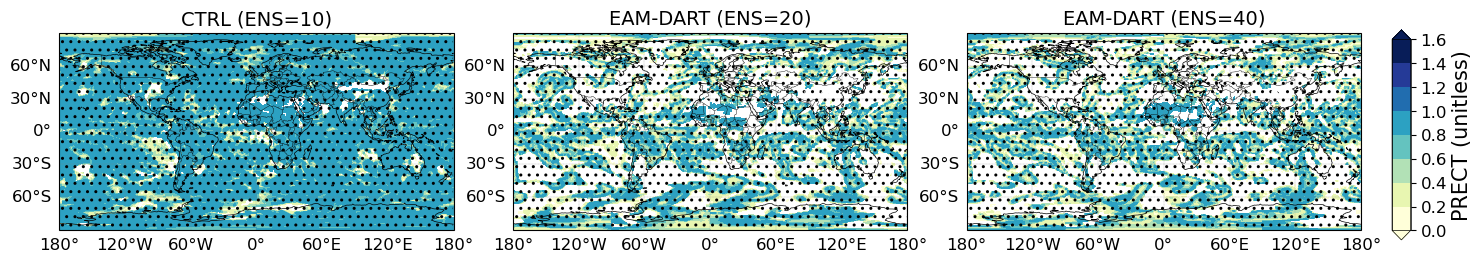

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PRECT_spread_map_DEC2011.pdf in 2.60 sec.
[WARN] Using fallback colormap 'RdBu_r'


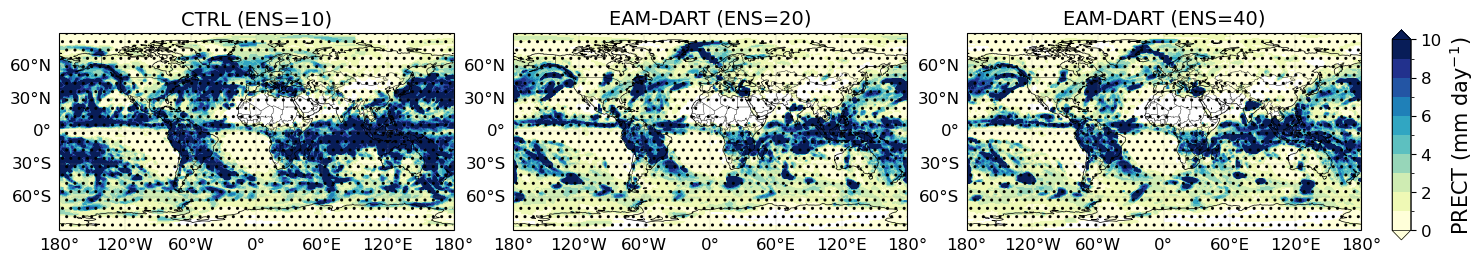

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PRECT_rmse_map_DEC2011.pdf in 2.86 sec.
[WARN] Using fallback colormap 'RdBu_r'


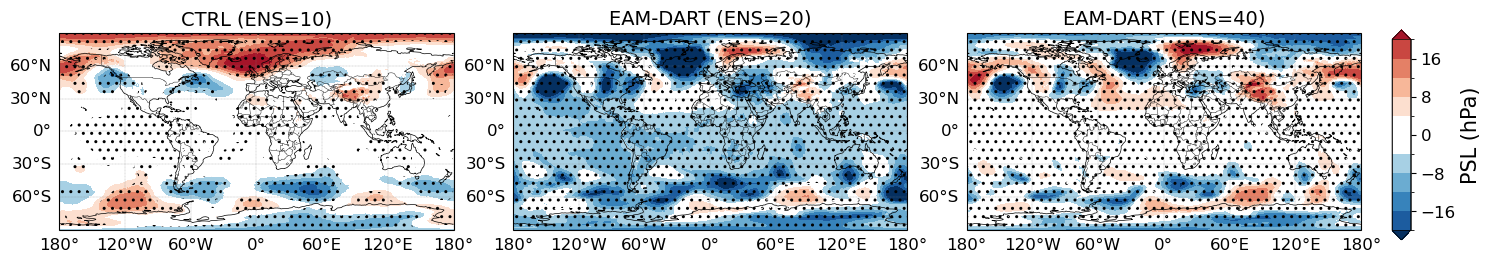

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PSL_bias_map_DEC2011.pdf in 1.78 sec.
[WARN] Using fallback colormap 'RdBu_r'


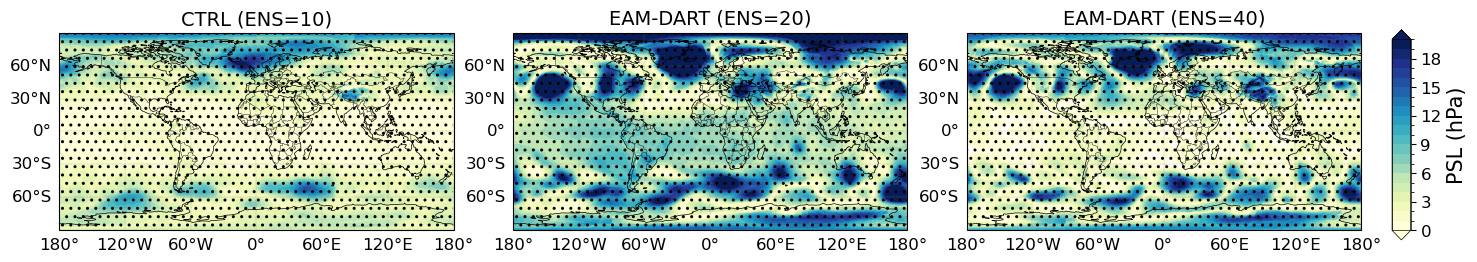

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PSL_crps_map_DEC2011.pdf in 2.41 sec.
[WARN] Using fallback colormap 'RdBu_r'


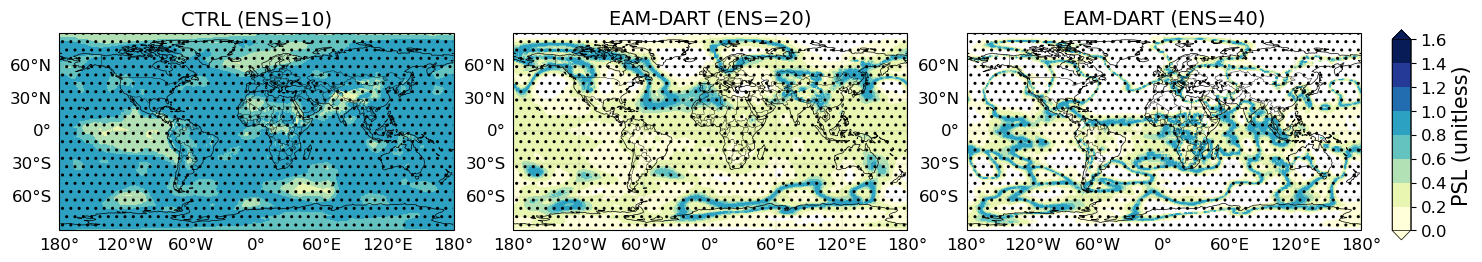

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PSL_spread_map_DEC2011.pdf in 1.88 sec.
[WARN] Using fallback colormap 'RdBu_r'


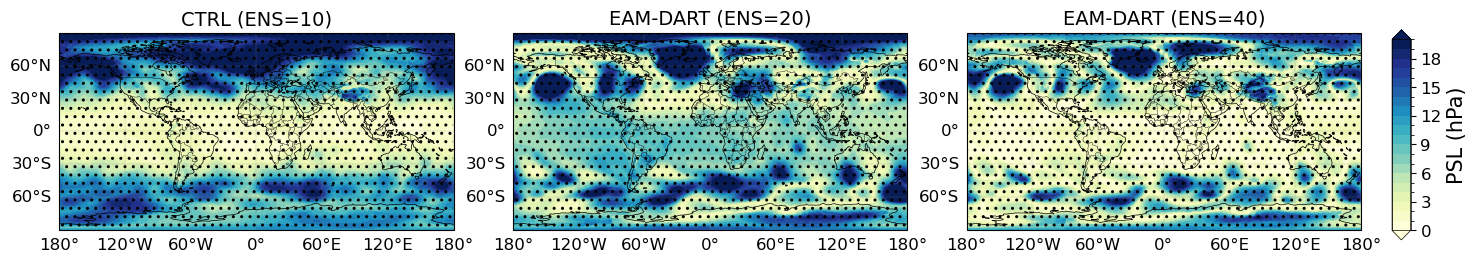

[INFO] Saved: /qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da/PSL_rmse_map_DEC2011.pdf in 2.69 sec.


In [5]:
if __name__ == "__main__":
    top_path = "/compyfs/zhan391/v3_dart_cda_scratch"
    out_path = os.path.join(top_path, "diag_dart")
    fig_path = "/qfs/people/zhan391/e3sm_dart_work/analysis/diagnostic/figures/mean_bias_da"
    mask_path = os.path.join(out_path,'landmask_1x1.nc')
    
    compset = "F20TR"
    resolution = "ne30pg2_r05_IcoswISC30E3r5"
    machine = "compy"
    exp_base = f"{compset}_{resolution}_{machine}"

    regnam = "global"
    period = "2011-12"
    frequency = "monthly"
    season = "DEC2011"
    var_dict = {
        'TS': {'alias': 'TS', 'unit': '$^o$C', 'level': np.linspace(-12, 12, 13), 'comp': 'atm', 'ref': "ERA5"},
        'TREFHT': {'alias': 'TREFHT', 'unit': '$^o$C', 'level': np.linspace(-12,12, 13), 'comp': 'atm', 'ref': "ERA5"},
        'PRECT': {'alias': 'PRECT', 'unit': 'mm day$^{-1}$', 'level': np.linspace(-10, 10, 11), 'comp': 'atm', 'ref': "ERA5"},
        'PSL': {'alias': 'PSL', 'unit': 'hPa', 'level': np.linspace(-20, 20, 11), 'comp': 'atm', 'ref': "ERA5"},
    }
    
    model_dict = {
        'CTRLEN10': "CTRL (ENS=10)",
        'DARTEN20': "EAM-DART (ENS=20)",
        'DARTEN40': "EAM-DART (ENS=40)",
        # You can include others like 'DARTEN10' or 'DARTEN80' if available
    }

    os.makedirs(out_path, exist_ok=True)
    os.makedirs(fig_path, exist_ok=True)

    plotter = SpatialMetricPlotter(mask_path)
    # Colormap: safe colorblind-friendly diverging
    cmap = cc.cm["CET_C9s"]  # Good for centered differences
    
    group_key = "ensemble_mean_bias"
    for var, vinfo in var_dict.items():
        for metric_key, mask_lower, mask_upper, metric_title in [
            ("bias_map", "bias_map_ci_lower","bias_map_ci_upper", "Mean Bias"),
            ("crps_map", "crps_map_ci_lower","crps_map_ci_upper", "CRPS"),
            ("spread_map", "spread_map_ci_lower","spread_map_ci_upper","Ensemble Spread"),
            ("rmse_map", "rmse_map_ci_lower","rmse_map_ci_upper", "RMSE")
        ]:
            try:
                plotter.plot_variable_metric(
                    out_path=out_path,
                    fig_path=fig_path,
                    model_dict=model_dict,
                    var=var,
                    vinfo=vinfo,
                    data_key=group_key,
                    metric_key=metric_key,
                    mask_lower=mask_lower,
                    mask_upper=mask_upper,
                    season=season
                )
            except Exception as e:
                print(f"[ERROR] Failed {var} {metric_key}: {e}")
